# Analisi del modello di Ekman con dati oceanografici
Virgilio Luca
### 1. Introduzione
Questo studio volge all'applicazione, alla stima dei parametri principali tramite MCMC e all'eventuale validazione del modello di Ekman ai dati raccolti dalla boa VIDA. 

Tale modello descrive il comportamento delle correnti marine sotto l'effetto combinato del vento e della forza di Coriolis, in particolare del loro andamento spiraliforme in funzione della profondità alla quale esse si trovino. 

L'analisi è stata ristretta all'evento di bora che ha interessato la strumentazione tra il 7 e il 9 gennaio 2024, che offre velocità e direzione del vento quasi costanti, e ad una profondità, misurata rispetto al fondale, compresa tra i 2 e i 20 metri, in modo da migliorare l'approssimazione del modello.

#### 1.1 Preparazione dati e conversione

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import matplotlib.colors as colors
import matplotlib.cm as cm

# Apertura foglio elettronico con pacchetto pandas e riordinamento dei dati
fileName = 'data.xlsx'
df = pd.read_excel(fileName)

# Eliminazione dati superflui 
# Il sito permette di scegliere i dati in un intervallo di tempo preciso prima di scaricarli
del df["Date and time"]
del df["Waves mean height"]
del df["Waves mean direction"]

meanWindSpeed = df["Mean Wind Speed"]
meanWindDir = df["Mean Wind Direction"]

# Filtro dei dati entro una deviazione standard
cutWindSpeed = (meanWindSpeed - meanWindSpeed.mean()).abs() < meanWindSpeed.std()
cutWindDir = (meanWindDir - meanWindDir.mean()).abs() < meanWindDir.std()
filter = cutWindSpeed * cutWindDir

# Calcolo velocità e direzione media del vento
meanWindSpeed = meanWindSpeed[filter].mean()
print("Velocità media del vento: {0:.3f} m/s".format(meanWindSpeed))

Velocità media del vento: 13.121 m/s


I dati relativi alla direzione del vento seguono una convenzione azimutale: immaginando i punti cardinali su un piano cartesiano, gli angoli crescono in senso orario a partire dal semiasse positivo delle ordinate (il Nord).
Inoltre, tale numero indica la direzione *da cui* proviene il vento, non quella in cui sta andando.

I dati sono stati convertiti opportunamente in modo che seguano la convenzione matematica (crescenti in senso antiorario a partire dal semiasse positivo delle ascisse):

In [2]:
meanWindDir = np.pi * (1 + meanWindDir[filter].mean() / 180)    # conversione in radianti + 180°
print("Direzione media del vento: {0:.3f}°".format(np.rad2deg(meanWindDir)))

Direzione media del vento: 237.037°


Come detto in precedenza, per i dati la profondità è la distanza dal fondale, ma il modello di Ekman richiede che essa sia misurata rispetto alla superficie. Per semplicità e coerenza, si è assunta la seconda convenzione:

In [3]:
# Imponendo la direzione E come ascissa e N come ordinata
# I dati filtrati sono una matrice, le cui colonne sono mediate in un vettore che viene riflesso
meanXCurrent = np.flip(df[filter].iloc[:, np.arange(2, 40, 2)].mean().to_numpy())
meanYCurrent = np.flip(df[filter].iloc[:, np.arange(3, 41, 2)].mean().to_numpy())

### 2. Visualizzazione dei dati e applicazione del modello di Ekman
#### 2.1 Grafico dei dati

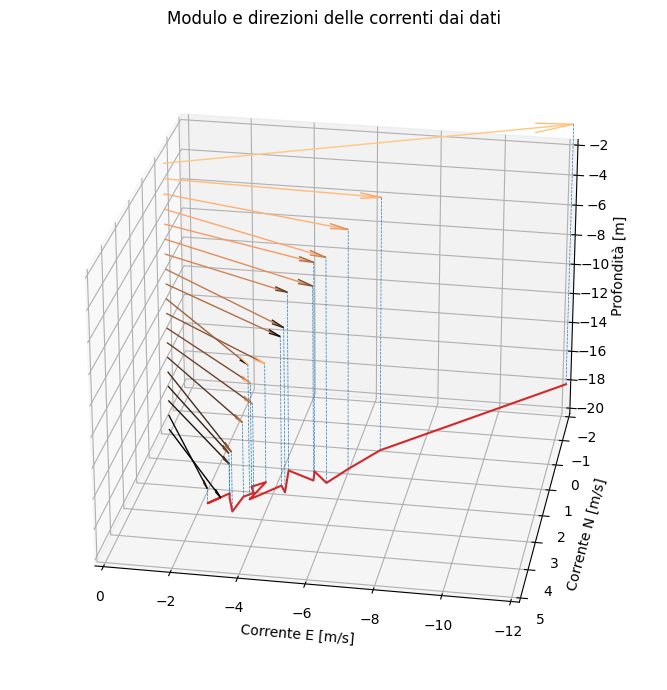

In [4]:
# Operazioni preliminari
# Vettore delle profondità (decrescenti)
z = -np.arange(2, 21, 1)
nullAx = np.zeros(len(z))

# Colori
norm = colors.Normalize(vmin = np.min(z), vmax = np.max(z))
dataMap = cm.copper
modelMap = cm.winter

dataColors = dataMap(norm(z)) 
modelColors = modelMap(norm(z)) 

# Grafico
fig = plt.figure(figsize = (10, 7))
plot = fig.add_subplot(projection = '3d')

# Vettori delle velocità delle correnti
step = 1
plot.quiver(nullAx, nullAx, z, 
            meanXCurrent, meanYCurrent, nullAx, 
            color = dataColors[::step], linewidth = 1, label = 'Dati', arrow_length_ratio=0.1)

# Proiezione della curva
stem = plot.stem(meanXCurrent, meanYCurrent, z, bottom = -20, linefmt = '--', markerfmt = ' ')
stem[1].set_linewidth(0.5)

# Visualizzazione migliore del grafico
plot.set_xlim([-12, 0])
plot.set_ylim([-2, 5])
plot.view_init(elev = 25, azim = 100)

# Titoli del grafico e assi
plot.set_title("Modulo e direzioni delle correnti dai dati")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")
plot.set_zlabel("Profondità [m]")

plt.tight_layout()
plt.show()

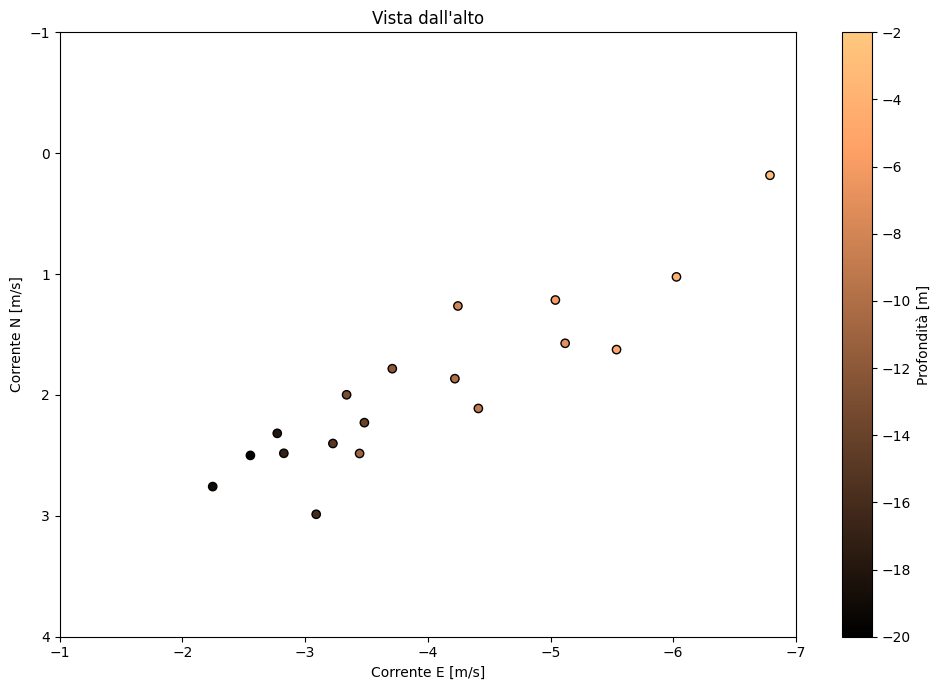

In [5]:
fig, plot = plt.subplots(figsize = (10, 7))

# Proiezione della curva
sc = plot.scatter(meanXCurrent, meanYCurrent, c = z, cmap = 'copper', edgecolors = 'black')
fig.colorbar(sc, label="Profondità [m]")

# Visualizzazione migliore del grafico
plot.set_xlim([-7, -1])
plot.set_ylim([-1, 4])
plot.invert_yaxis()
plot.invert_xaxis()

# Titoli del grafico e assi
plot.set_title("Vista dall'alto")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")

plt.tight_layout()
plt.show()

#### 2.2 Modello di Ekman
Il modello di Ekman è descritto dalle seguenti equazioni, rispettivamente per la corrente verso Est e Nord:
$$
v_x(z)=v_x^\infty + \frac{\sqrt{2}}{\rho fd}e^{z/d}\left(\tau_x \cos\left(\frac{z}{d}-\varphi\right)-\tau_y \sin\left(\frac{z}{d}-\varphi\right)\right)
$$
$$
v_y(z)=v_y^\infty + \frac{\sqrt{2}}{\rho fd}e^{z/d}\left(\tau_x \sin\left(\frac{z}{d}-\varphi\right)+\tau_y \cos\left(\frac{z}{d}-\varphi\right)\right)
$$
che presentano i seguenti parametri:
- $\boldsymbol{\rho}$: la densità dell'acqua marina
- $\boldsymbol{f=2\Omega \sin(\phi)}$: il parametro di Coriolis, definito a sua volta dalla velocità di rotazione terrestre $\Omega$ e la latitudine di riferimento $\phi$
- $\boldsymbol{v_*^\infty}$: le componenti di velocità della corrente nel limite $z\rightarrow \text{-}\infty$
- $\boldsymbol{d}$: la profondità dello strato di Ekman, che indica il punto in cui il vento in superficie non riesce più a influenzare il moto delle correnti, quindi l'altezza della spirale.
- $\boldsymbol{\tau}$: il modulo dello stress superficiale del campo del vento, qui scomposto nelle sue componenti ortogonali: $\tau_x=\tau \cos\theta$, $\tau_y=\tau \sin\theta$, dove $\theta$ è la direzione del vento.
- $\boldsymbol{\varphi}$: la differenza angolare tra la direzione del vento e la corrente superficiale, convenzionalmente definita negativa nell'emisfero boreale, sarà considerata positiva per semplicità e coerenza.

$\rho$ e $\phi$ (quindi $f$) possono essere fissati con moderata certezza, mentre per gli altri parametri è necessaria una stima con un approccio Bayesiano. Tale procedimento richiede un *Ansatz* iniziale sui parametri, che può essere inizialmente usato per mostrare, almeno in prima approssimazione, la spirale di Ekman ed il suo rapporto con i dati. In particolare:

In [6]:
# Il Mare Adriatico ha una salinità media di 38.30 g/L che corrispondono circa alla densità riportata
rho = 1026

# Il sito del NIB riporta 45.13 N al momento della scrittura, è stata comunque usata la latitudine suggerita
latitude = 45.55        
omega = 7.2921e-5
f = 2 * omega * np.sin(np.deg2rad(latitude))

# Valori iniziali dei parametri (dalla consegna)
tau = 8
d = 16
sigma = 0.5

# Stimato computando la differenza tra la direzione del vento e della corrente più vicina alla superficie
# In linea con osservazioni empiriche
phi = np.abs(2*np.pi + np.arctan2(meanYCurrent[0], meanXCurrent[0]) - meanWindDir)

# Stimati mediando i valori più profondi delle componenti delle velocità
v_x_inf = meanXCurrent[18:20].mean()               
v_y_inf = meanYCurrent[18:20].mean()

|$\boldsymbol{\rho}$|$\boldsymbol{\phi}$|$\boldsymbol{f}$|$\boldsymbol{\tau}$|$\boldsymbol{d}$|$\boldsymbol{\varphi}$|$\boldsymbol{v_x^\infty}$|$\boldsymbol{v_y^\infty}$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1026 kg/m$^3$|45.55°|0.10 mHz|8 N/m$^2$|16 m|42.21°|-2.5 m/s|2.5 m/s|

#### 2.3 Grafico del modello di Ekman
Le equazioni che descrivono il modello possono essere riscritte nel seguente modo, usando le formule di addizione di seno e coseno e ricomponendo $\tau$:

$$
v_x(z)=v_x^\infty + \frac{\tau\sqrt{2}}{\rho fd}e^{z/d}\cos\left(\theta - \varphi+ \frac{z}{d}\right); \quad v_y(z)=v_y^\infty + \frac{\tau\sqrt{2}}{\rho fd}e^{z/d}\sin\left(\theta - \varphi + \frac{z}{d}\right)
$$

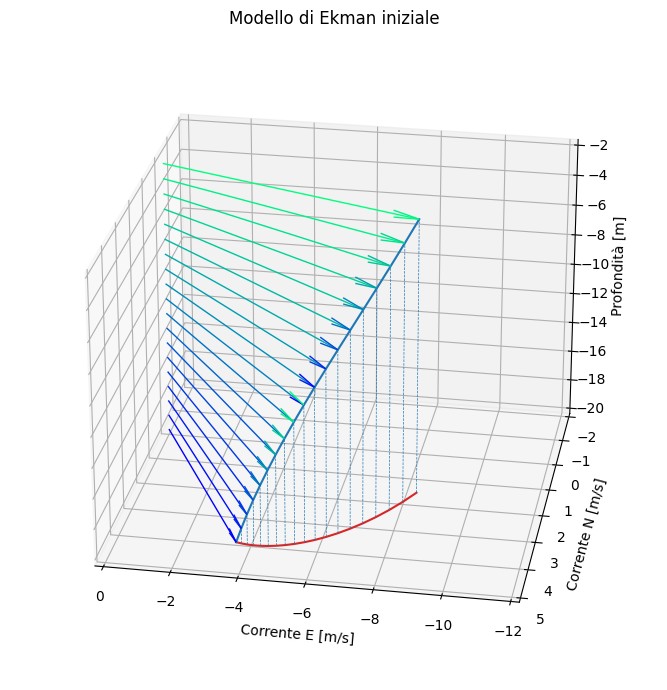

In [7]:
# Modello di Ekman
def ekman(z, params):
    tau, d, phi, v_x_inf, v_y_inf = params

    tau_x = tau * np.cos(meanWindDir - phi + z/d)
    tau_y = tau * np.sin(meanWindDir - phi + z/d)

    exp = np.exp(z / d)

    v_x = v_x_inf + ((2**0.5 * exp * tau_x) / (rho * f * d))
    v_y = v_y_inf + ((2**0.5 * exp * tau_y) / (rho * f * d))

    return v_x, v_y

# Predizioni teoriche iniziali
v_x, v_y = ekman(z, (tau, d, phi, v_x_inf, v_y_inf))

# Grafico
fig = plt.figure(figsize = (10, 7))
plot = fig.add_subplot(projection = '3d')

# Vettori delle velocità delle correnti (nel modello)
step = 1
plot.quiver(nullAx, nullAx, z, 
            v_x, v_y, nullAx, 
            color = modelColors[::step], linewidth = 1, label = 'Spirale di Ekman', arrow_length_ratio = 0.1)

# Proiezione della curva
stem = plot.stem(v_x, v_y, z, bottom = -20, linefmt = '--', markerfmt = '')
stem[1].set_linewidth(0.5)

# Visualizzazione migliore del grafico
plot.set_xlim([-12, 0])
plot.set_ylim([-2, 5])
plot.view_init(elev = 25, azim = 100)

# Titoli del grafico e assi
plot.set_title("Modello di Ekman iniziale")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")
plot.set_zlabel("Profondità [m]")

plt.tight_layout()
plt.show()

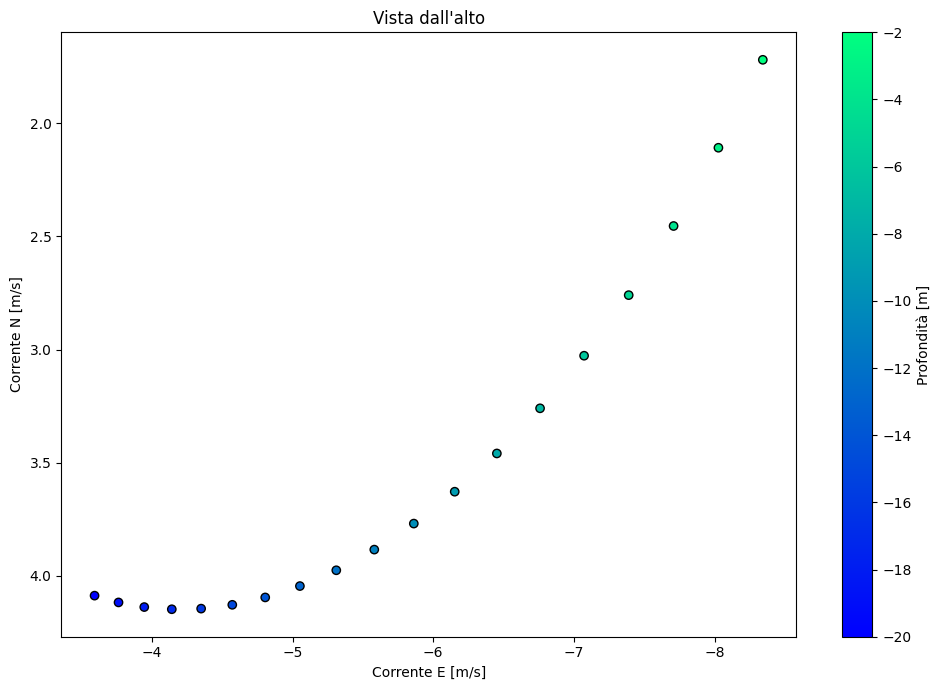

In [8]:
fig, plot = plt.subplots(figsize = (10, 7))

# Proiezione della curva
sc = plot.scatter(v_x, v_y, c = z, cmap = 'winter', edgecolors = 'black')
fig.colorbar(sc, label="Profondità [m]")

# Visualizzazione migliore del grafico
plot.invert_yaxis()
plot.invert_xaxis()

# Titoli del grafico e assi
plot.set_title("Vista dall'alto")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")

plt.tight_layout()
plt.show()

### 3. Inferenza bayesiana e campionamento MCMC
Un procedimento per la stima ottimale dei parametri è la combinazione di inferenza bayesiana con campionamento MCMC (metodo Monte Carlo basato su Catena di Markov) 

#### 3.1 Funzione di Likelihood
Assumendo che le velocità della corrente siano affette da un errore di misura gaussiano $\sigma$ = 0.5 m/s, si può costruire la funzione di verosimiglianza:

$$
\mathcal{L} = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\,\exp\left(-\frac{(v_{x,i}-v_{x,i}^{mod})^2+(v_{y,i}-v_{y,i}^{mod})^2}{2\sigma^2}\right)
$$
che definisce la probabilità di ritrovare le velocità osservate, dati i parametri. Siccome si intende massimizzare questa funzione, è prassi prenderne il logaritmo per alleggerire i calcoli:
$$
\ln\mathcal L=-\frac{N}{2}\ln\left(2\pi\sigma^2\right)-\frac{1}{2\sigma^2}\sum_{i=1}^N\left((v_{x,i}-v_{x,i}^{mod})^2+(v_{y,i}-v_{y,i}^{mod})^2\right)
$$
dove $v_{*,i}$ e $v_{*,i}^{mod}$ sono rispettivamente le componenti delle correnti osservate e teoriche alla i-esima profondità z = {-2, -3, ..., -20}

In [9]:
# Funzione di verosimiglianza
def logLikelihood(params, z, v_x, v_y, sigma):
    tau, d, phi, v_x_inf, v_y_inf = params
    v_x_modello, v_y_modello = ekman(z, (tau, d, phi, v_x_inf, v_y_inf))

    sum = np.sum(((v_x - v_x_modello)**2 + (v_y - v_y_modello)**2))

    return (-0.5 / sigma**2) * sum - len(z) * np.log(2 * np.pi * sigma**2)

#### 3.2 Distribuzione a priori e a posteriori

Il teorema di Bayes dice che si può aggiornare il proprio modello iniziale (*prior*), in base ai nuovi dati o evidenze (*likelihood*), formulando una nuova ipotesi a posteriori (*posterior*).
$$
P(A|B)=\frac{P(B|A)\cdot P(A)}{P(B)}
$$
Nel caso in esame, il *prior* è una distribuzione uniforme sui parametri del modello, in modo che, definito un intervallo ragionevole, tutti i valori al di fuori siano esclusi dall'inferenza, mentre che quelli interni abbiano la medesima probabilità di essere pescati:
$$
\ln P(\theta) = \begin{cases}
 0 & 0 < \tau < 20, \ 5 < d < 30, \ \text{-}\pi < \varphi < \pi, \ \text{-}10 < v_x^\infty < 10, \ \text{-}10 < v_y^\infty < 10 \\
 -\infty & \text{altrimenti}
 \end{cases}
$$

In [10]:
# Logaritmo del prior uniforme
def logPrior(params):
    tau, d, phi, v_x_inf, v_y_inf = params

    if (0 < tau < 20):
        return 0
    if (5 < d < 30):
        return 0
    if (-np.pi < phi < np.pi):
        return 0
    if (-10 < v_x_inf < 10):
        return 0
    if (-10 < v_y_inf < 10):
        return 0
        
    return -np.inf

Mentre il *posterior* è semplicemente la somma (logaritmo di un prodotto) tra la funzione di *likelihood* e il *prior*, come da teorema, che quindi descrive la probabilità di ritrovare determinati parametri, date le velocità osservate:
$$
\ln P(\theta\,|\,(v_x, v_y)) = \ln P(\theta) + \ln P((v_x, v_y)\,|\,\theta) = \ln P(\theta) + \ln \mathcal{L}
$$

In [11]:
# Logaritmo del posterior
def logPosterior(params, z, v_x, v_y, sigma):
    lp = logPrior(params)

    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(params, z, v_x, v_y, sigma)

In particolare, se i valori dei parametri dovessero risultare assurdi, anche la funzione *posterior* restituisce $\text{-}\infty$, in modo che essi vengano esclusi dal campionamento ($e^{\text{-}\infty}$ = 0)
#### 3.3 Algoritmo *emcee*
Prima di passare al campionamento, è utile ottimizzare i parametri iniziali:
massimizzare il *posterior*, che è equivalente a minimizzarne il negativo, restituisce i valori per i parametri che hanno la maggior probabilità di replicare i dati osservati.

In [12]:
from scipy.optimize import minimize
np.random.seed(1225)

nll = lambda *args: -logPosterior(*args)
ansatz = np.array([tau, d, phi, v_x_inf, v_y_inf])
print("valori iniziali:    ", ansatz)

bestAnsatz = minimize(nll, ansatz, args = (z, v_x, v_y, sigma)).x
print("valori ottimizzati: ", bestAnsatz)

valori iniziali:     [ 8.         16.          0.73662306 -2.55362319  2.5       ]
valori ottimizzati:  [ 8.         16.          0.73662306 -2.55362319  2.5       ]


Si nota facilmente che questo passaggio è completamente superfluo, in quanto l'approccio iniziale è già ottimizzato; verrà lasciato nella relazione per completezza.

Per il campionamento dei parametri è stata utilizzata la libreria *emcee*, che implementa un algoritmo basato su un insieme di "camminatori" (*walkers*).
Una volta inizializzati con delle posizioni di partezza, essi esplorano in maniera casuale lo spazio multidimensionale dei parametri, campionando man mano la distribuzione del *posterior*, che può essere usata per un'analisi statistica successiva.

100%|██████████████████████████████████████| 5000/5000 [00:19<00:00, 255.62it/s]


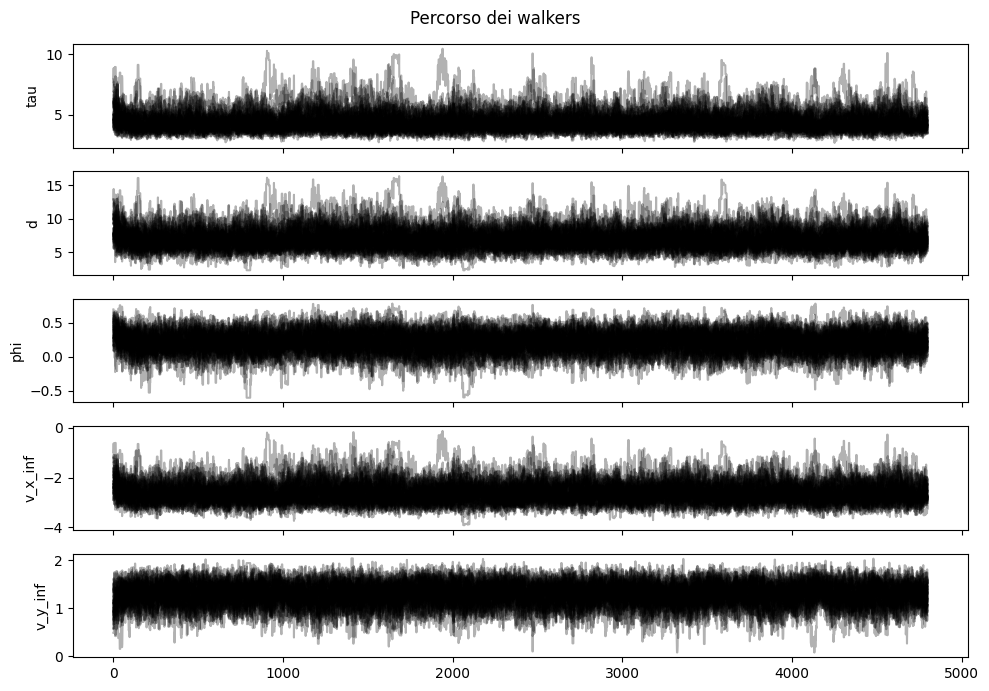

In [30]:
# Setup camminatori
numParams = 5
numWalkers = 50
pos = ansatz + 1e-4 * np.random.randn(numWalkers, numParams)

# Setup campionatore
sampler = emcee.EnsembleSampler(
    numWalkers, numParams, logPosterior, 
    args = (z, meanXCurrent, meanYCurrent, sigma))

# Soppressione degli avvisi di overflow
# non compare abbastanza spesso per meritare una soluzione migliore
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

# Campionamento dei parametri
sampler.run_mcmc(pos, 5000, progress = True)
samples = sampler.get_chain(discard = 200)

# Grafico del percorso dei camminatori
labels = ["tau","d", "phi", "v_x_inf", "v_y_inf"]
fig, plots = plt.subplots(numParams, figsize = (10, 7), sharex = True)
for i, label in enumerate(labels):
    plot = plots[i]
    plot.plot(samples[:, :, i], color = "black", alpha = 0.3)
    plot.set_ylabel(labels[i])

fig.suptitle('Percorso dei walkers')
plt.tight_layout()
plt.show()

In [14]:
# Calcolo dei parametri
paramLabels = (["tau", "d", "phi", "v_x_inf", "v_y_inf"])
bestParams = np.mean(np.mean(samples, axis = 0), axis = 0)
sigmaParams = np.std(np.std(samples, axis = 0), axis = 0)

for i in range(0, len(bestParams)):
    print("{0} = {1:.3f} ± {2:.3f}".format(paramLabels[i], bestParams[i], sigmaParams[i]))

tau = 4.404 ± 0.101
d = 6.971 ± 0.163
phi = 0.213 ± 0.014
v_x_inf = -2.620 ± 0.042
v_y_inf = 1.294 ± 0.023


Mentre le correnti di fondo e lo stress risultano compatibili con l'ipotesi iniziale, gli altri valori  sono minori dall'ipotesi iniziale: in un bacino d'acqua poco profondo come l'Adriatico la spirale di Ekman non riesce a svilupparsi completamente, di conseguenza l'omonima profondità e l'angolo tra la corrente e il vento risultano entrambi minori delle aspettative.
### 4. Verifica della bontà del fit
#### 4.1 Confronto diretto tra modello e dati

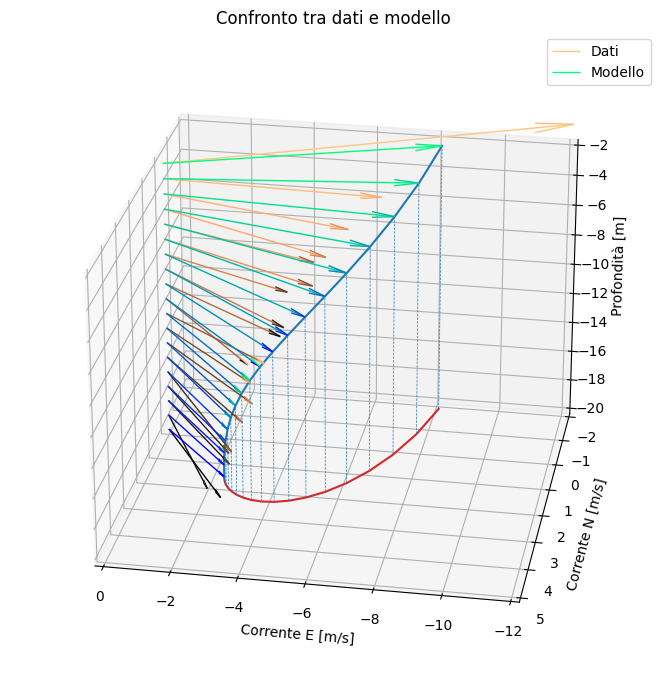

In [29]:
v_x, v_y = ekman(z, bestParams)

# Grafico
fig = plt.figure(figsize = (10, 7))
plot = fig.add_subplot(projection = '3d')

# Vettori delle velocità delle correnti
step = 1
plot.quiver(nullAx, nullAx, z, 
            meanXCurrent, meanYCurrent, nullAx, 
            color = dataColors[::step], linewidth = 1, label = 'Dati', arrow_length_ratio = 0.1)

# Vettori delle velocità delle correnti (nel modello)
step = 1
plot.quiver(nullAx, nullAx, z, 
            v_x, v_y, nullAx, 
            color = modelColors[::step], linewidth = 1, 
            label = 'Modello', arrow_length_ratio = 0.1)

# Proiezione della curva
stem = plot.stem(v_x, v_y, z, bottom = -20, linefmt = '--', markerfmt = '')
stem[1].set_linewidth(0.5)

# Visualizzazione migliore del grafico
plot.set_xlim([-12, 0])
plot.set_ylim([-2, 5])
plot.view_init(elev = 25, azim = 100)

# Titoli del grafico e assi
plot.set_title("Confronto tra dati e modello")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")
plot.set_zlabel("Profondità [m]")

plt.tight_layout()
plt.legend()
plt.show()

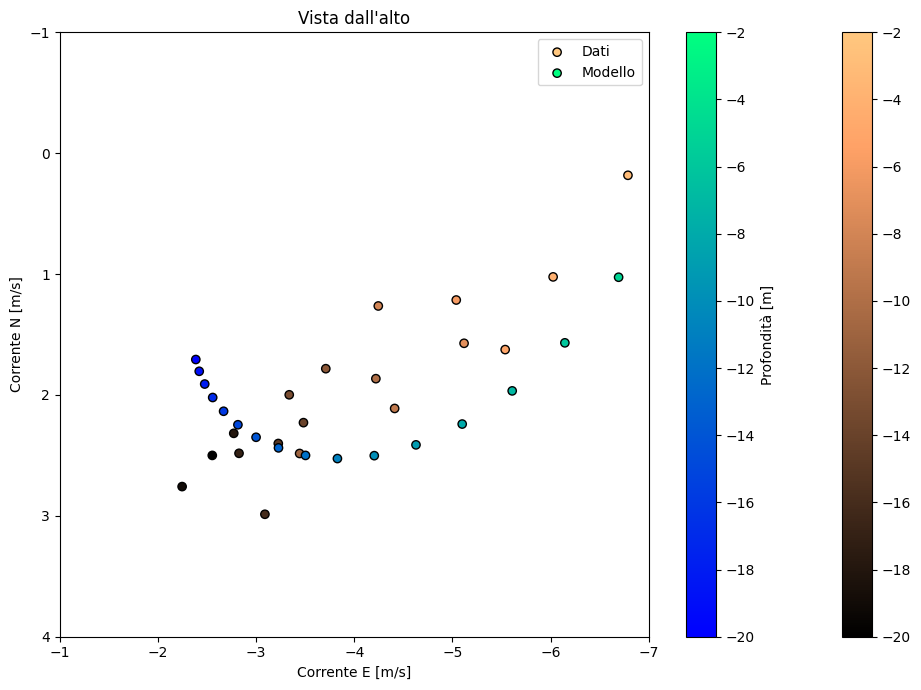

In [21]:
fig, plot = plt.subplots(figsize = (10, 7))

# Proiezione della curva
sc = plot.scatter(meanXCurrent, meanYCurrent, c = z, cmap = 'copper', edgecolor = 'black', label = "Dati")
fig.colorbar(sc)

sc = plot.scatter(v_x, v_y, c = z, cmap = 'winter', edgecolor = 'black', label = 'Modello')
fig.colorbar(sc, label="Profondità [m]")

# Visualizzazione migliore del grafico
plot.set_xlim([-7, -1])
plot.set_ylim([-1, 4])
plot.invert_yaxis()
plot.invert_xaxis()

# Titoli del grafico e assi
plot.set_title("Vista dall'alto")
plot.set_xlabel("Corrente E [m/s]")
plot.set_ylabel("Corrente N [m/s]")

plt.tight_layout()
plt.legend()
plt.show()

#### 4.2 Grafico dei residui
Un secondo metodo consiste nel calcolare i residui per le 2 grandezze in gioco e controllare che essi siano o meno distribuiti attorno allo 0:
$$
\text{Res}(v_{x,i})=v_{x,i}-v_{x,i}^{mod}\quad\text{Res}(v_{y,i})=v_{y,i}-v_{y,i}^{mod}
$$

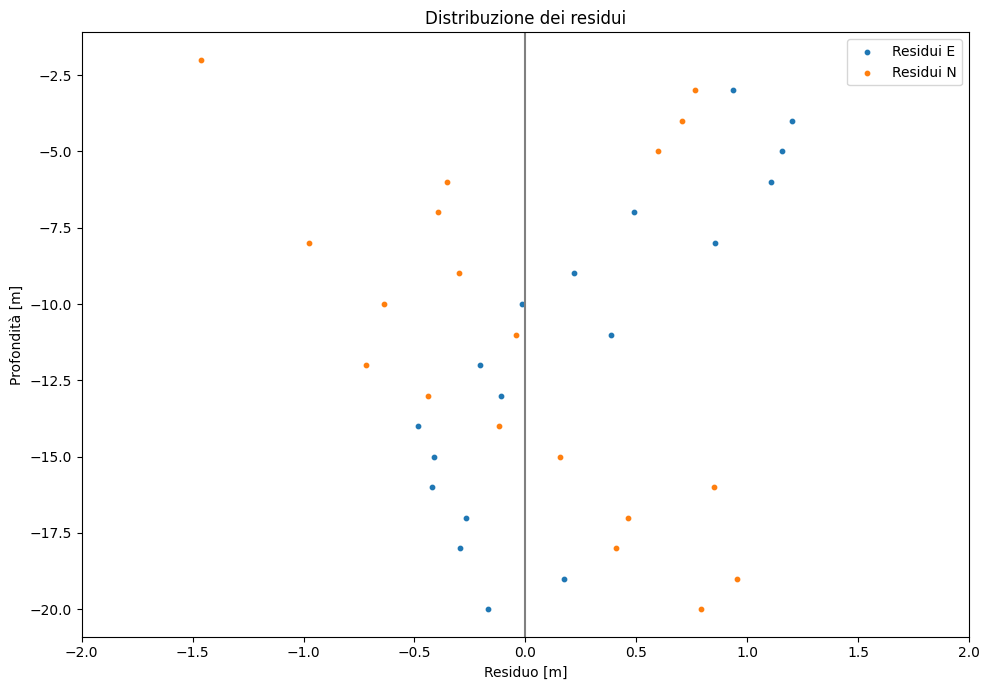

In [17]:
# Calcolo dei residui
res_v_x = meanXCurrent - v_x
res_v_y = meanYCurrent - v_y

# Grafico
fig = plt.figure(figsize = (10, 7))
plot = fig.add_subplot()

plot.scatter(res_v_x, z, s = 10.0, label = 'Residui E')
plot.scatter(res_v_y, z, s = 10.0, label = 'Residui N')
plot.axvline(0, color = 'gray')

# Titoli del grafico e assi
plot.set_title("Distribuzione dei residui")
plot.set_xlabel("Residuo [m]")
plot.set_ylabel("Profondità [m]")

plot.set_xlim([-2, 2])

plt.legend()
plt.tight_layout()
plt.show()

#### 4.3 Test del $\chi^2$
L'ultimo metodo consiste nel calcolo della seguente quantità:
$$
\chi_{rid}^2 = \frac{\chi^2}{n_{dof}}=\frac{1}{n_{dof}}\frac{1}{\sigma^2}\sum_{i=1}^N\left[ \left(v_{x,i}-v_{x,i}^{mod} \right)^2 + \left( v_{y,i}-v_{y,i}^{mod} \right)^2\right]
$$
dove $n_{dof}$ è il numero di gradi di libertà del sistema, ovvero il numero di variabili indipendenti.

Il valore ottenuto fornisce una valutazione qualitativa del modello:
- se $\chi^2_{rid} \approx 1$ allora esso si adatta bene ai dati.
- se $\chi^2_{rid} \ll 1$ o $\chi^2_{rid} \gg 1$ gli errori potrebbero essere rispettivamente sovrastimati o sottostimati, oppure i dati non sono descritti efficacemente.

In [18]:
chi2 = np.sum(res_v_x**2 + res_v_y**2) / sigma**2
dof = 2 * len(z) - 5  # 2N dati, 5 parametri stimati

print("chi2rid = " + str(round(chi2 / dof, 3)))

chi2rid = 3.624


### 5 Conclusioni

Come si poteva anticipare dai grafici mostrati, quello di Ekman è un modello troppo idealizzato per poter essere applicato da solo a dei dati reali; di fatto esso richiede:
- un oceano di profondità e ampiezza infinita, affetto unicamente dalle forze in gioco nel modello, che quindi implicherebbe l'assenza totale di fenomeni turbolenti o correnti slegate al trasporto di Ekman.
- un vento costante in velocità e direzione: per quanto l'evento di bora possa fornire dati consistenti, non è di certo immune a variazioni nel tempo, che producono le turbolenze menzionate poco fa.

Ciononostante i vettori corrispondenti alle velocità seguono grossomodo l'andamento della spirale di Ekman: si accorciano con la profondità e ruotano in senso orario.

Di fatto il $\chi^2_{rid}$ è pesantemente influenzato da dati anomali, quali la corrente vicino alla superficie, il modello potrebbe essere più adatto di quanto sembri: il grafico dei residui favorisce quest'ipotesi. 

Inoltre il test del $\chi^2$ richiede che gli errori siano costanti e indipendenti, cosa non necessariamente vera nella realtà; imponendo una distribuzione sulle incertezze potrebbe potenzialmente migliorare il fit.